# Navigation

---

This notebook provides a solution to completing the Unity ML-Agents' Banana environment provided as a part of the
[Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

The notebook assumes that the Banana environment is provided for the Linux platform and its files are located in `./Banana_linux/`.

## Header

Enable auto-reloading of depending modules

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

Import required packages

In [3]:
from unityagents import UnityEnvironment
import numpy as np

from dqn_agent import Agent
from collections import deque

import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Importing environment `Banana.x86_64` and set the default "Brain".

In [4]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
print(f"brain_name: {brain_name}")
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


brain_name: BananaBrain


### The Environment

In this environment we are an agent whose goal is to collect yellow bananas and avoid blue bananas. Each banana collection yields a reward with `+1` and `-1` being provided for a yellow and blue banana, respectively. 

At each instance, the agent can only perform one of **four actions** encoded with integers:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The **state space** is larger (`37` dimensions) and it contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.

Cell bellow shows information direclly from the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)
print('Exemplary state:', state)

Number of agents: 1
Number of actions: 4
States have length: 37
Exemplary state: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]


By executing the cell below you'll see random walk within the instantiated environment. Please note that even with the random walk it's possible to collect a high score, though highly unlikely.

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

while True: # Refresh ~100ms
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

# Agent training

Our brave agent is based on the (D)QN, i.e. (deep) Q-Learning Network. It uses the neural network to estimate the action based on the state with Q-learning used to update the policy. Although the network is completly different, some learning concepts/tricks are taken from the DeepMind's DQN presented in "Human-level control through deep reinforcment learning" ([link](https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf))

Inspired concepts include:
* Experience reply
* Dual network with fixed Q-target

In [20]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=32167)

The neural architecture consists of 3 fully connected layers with rectified linear unit (ReLU) activation function.

In [21]:
agent.qnetwork_local  # agent.qnetwork_target has the same architecture

QNetwork(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

Hyperparameters chosen for the training were selected as those that crossed the threshold of `score = 13`, however, the starting setting was the default provided in the project template and there weren't many evalutions to check whether these are the global optimal. There are many factors that affect the learning slope and it's expected that in our simulation the main differnce is the random generator's seed value.

Hyperparameters:
* Learning rate $\lambda = 0.001$
* Discount $\gamma = 0.99$
* Buffer size $B_s = 100 000$
* Minibatch size $B_m = 32$
* Update frequency $uf = 8$ frames

Below we execute the agent on the environment and store its scores for each evaluation.

In [9]:
def dqn(agent, n_episodes=200, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    # Save trained network
    torch.save(agent.qnetwork_local.state_dict(), 'dqn_local_state.pth')
    return scores

Evaluating the agent on 1000 episodes

In [10]:
scores = dqn(agent, n_episodes=1000, max_t=10000)

Episode 100	Average Score: 0.23
Episode 200	Average Score: 3.30
Episode 300	Average Score: 6.72
Episode 400	Average Score: 10.23
Episode 500	Average Score: 12.52
Episode 600	Average Score: 15.18
Episode 700	Average Score: 15.41
Episode 800	Average Score: 15.29
Episode 900	Average Score: 15.83
Episode 1000	Average Score: 16.17


Plot below shows how the score changes depending on number of evaluations

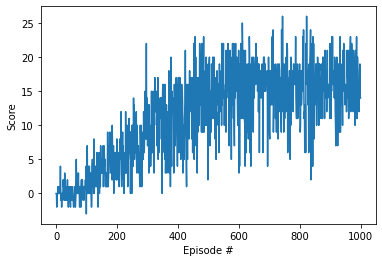

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Results

In [22]:
# The `model.pth` is a pretrained model on the same configuration as above.
# In case you have change settings and prefer to use the one just trained,
# feel free to rename the path to `dqn_local_state.pth`.
agent.qnetwork_local.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [23]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
eps = 0.1

while True: # Refresh ~100ms
    action = agent.act(state, eps)
            
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 18.0


In [24]:
env.close()